In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle

# import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check the sys path to see if the current directory is in the path in colab
import sys
print(sys.path)


['c:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\python310.zip', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\DLLs', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1', '', 'C:\\Users\\Kyriakos\\AppData\\Roaming\\Python\\Python310\\site-packages', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\win32', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\Pythonwin']


In [12]:
df = pd.read_csv('dataset\listings_comments.csv')

In [4]:
# load comments embeddings
with open('embeddings\comments_embeddings.pkl', 'rb') as f:
    comments_embeddings = pickle.load(f)

In [5]:
comments_embeddings.shape

(6998, 384)

In [6]:
# pd.set_option('display.max_colwidth', None)
df.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'name', 'description', 'neighborhood_overview', 'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_n

In [7]:
label  = df['review_scores_accuracy'].values

In [8]:
# from embedding.py load the function visualize_3D
from visualization.embedding import *

In [10]:
# from embeddings use the visualize_3D function to visualize the embeddings
visualize_3D(comments_embeddings, label, title="Comments Embeddings", method='tSNE', method_settings={"perplexity":30, "random_state":0})

: 

: 

In [9]:
print(df['comments'].isna().sum())
# fill the nan values in the comments column with 'nan_value'
df['comments'].fillna('nan_value', inplace=True)

682


In [18]:
import nltk
from nltk.corpus import stopwords
import string

# define the stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
punctuations = set(string.punctuation)
# stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
positive_df = df[df['review_scores_accuracy'] >= 4.5]
# neutral_df between 4.1 and 4.5
neutral_df = df[(df['review_scores_accuracy'] >= 4.1) & (df['review_scores_accuracy'] < 4.5)]
# negative_df less than 4.1
negative_df = df[df['review_scores_accuracy'] < 4.1]

positive_df.shape, neutral_df.shape, negative_df.shape

((6001, 76), (202, 76), (109, 76))

In [64]:

import re
import nltk
from nltk.corpus import stopwords
import string

# define the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# Define regular expression pattern to match stop words
stop_word_regex = r'\b(?:{})\b'.format('|'.join(stop_words))

#  Defining regex for emojis
smileemoji = r"[8:=;]['`\-]?[)d]+"
sademoji = r"[8:=;]['`\-]?\(+"
neutralemoji = r"[8:=;]['`\-]?[\/|l*]"
lolemoji = r"[8:=;]['`\-]?p+"

# pattern for unicode characters
pattern_unicode = r'\\u[0-9A-Fa-f]{4}'

# uncontract the words -eplaces contractions in the text with their corresponding full forms
def uncontract(text):    
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    
    return text


# we create a function to pre process the text and we have a default value for normalization. we can change it to stemming or lemmatization
# to check which one is better for our model

def preprocess_text(text, normalization="stemming"):
    # text in the list to lower
    text = [t.lower() for t in text]
    

    # Replace all emojis.
    text = [re.sub(r'<3', '<heart>', t) for t in text]
    text = [re.sub(smileemoji, '<smile>', t) for t in text]
    text = [re.sub(sademoji, '<sadface>', t) for t in text]
    text = [re.sub(neutralemoji, '<neutralface>', t) for t in text]
    text = [re.sub(lolemoji, '<lolface>', t) for t in text]
    
    
    # split and remove the unicode characters
    text = [re.sub(pattern_unicode, '', t) for t in text]

    

    # remove consecutive characters heyyyyy -> heyy
    text = [re.sub(r'(.)\1+', r'\1\1', t) for t in text]

    # Remove punctuation tokens 
    punctuations = set(filter(lambda t: all(c.isdigit() or c in string.punctuation for c in t), text))
    text = [t for t in text if t not in punctuations]


#     # Remove stopwords 
    text = [re.sub(stop_word_regex, '', t) for t in text]



    #removing shortwords smaller that 3 characters
    clean_tokens = [w for w in text if len(w)>=3]


#     Apply stemming  or lemmatization 
    
    if normalization == "stemming":
        for i, t in enumerate(clean_tokens):        
            t = ps.stem(t)
            clean_tokens[i] = t

    else:
        print("lemmatization")
        for i, t in enumerate(clean_tokens):
            t = lemmatizer.lemmatize(t)
            clean_tokens[i] = t

    return [t for t in clean_tokens if len(t) > 0]





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
# uncontract("I'm not going to do itiii, heyyyyyyyyy")
# preprocess_text("I'm not going to do itiii, heyyyyyyyyy")

In [65]:
positive_comments = [str(comment) for comment in positive_df['comments'] if isinstance(comment, str)]
positive_comments = ''.join(positive_comments).split()

neutral_comments = [str(comment) for comment in neutral_df['comments'] if isinstance(comment, str)]
neutral_comments = ''.join(neutral_comments).split()

negative_comments = [str(comment) for comment in negative_df['comments'] if isinstance(comment, str)]
negative_comments = ''.join(negative_comments).split()

In [68]:
# preprocess the comments with stemming

positive_comments = preprocess_text(positive_comments, "lemmatization")
neutral_comments = preprocess_text(neutral_comments, "lemmatization")
negative_comments = preprocess_text(negative_comments, "lemmatization")

lemmatization
lemmatization
lemmatization


In [81]:
# remove neutral and popular words like "amstermdam", "location", "apartment", "br", "place"  comments
remove_words = ["amsterdam", "location", "apartment", "br", "place", "house", "room", "flat", "home", "host"]
positive_comments = [word for word in positive_comments if word not in remove_words]
negative_comments = [word for word in negative_comments if word not in remove_words]
neutral_comments = [word for word in neutral_comments if word not in remove_words]


In [82]:
# apply the wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# positive comments
positive_wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(' '.join(positive_comments))
neutral_wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(' '.join(neutral_comments))
negative_wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(' '.join(negative_comments))


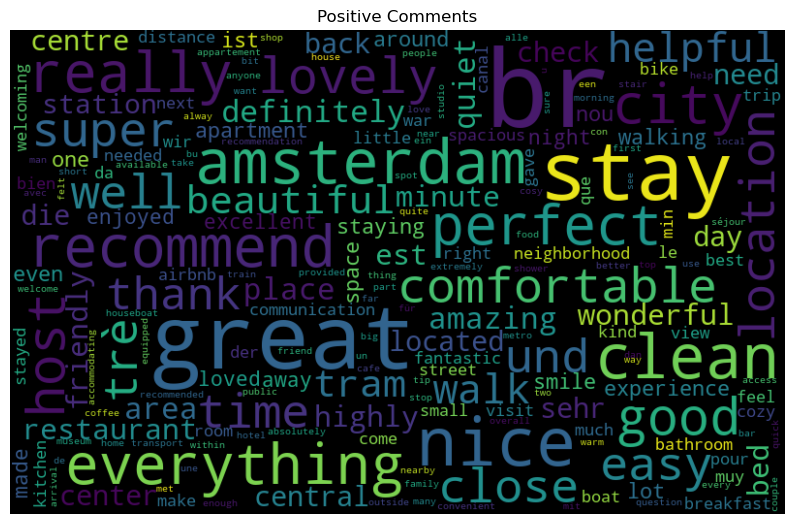

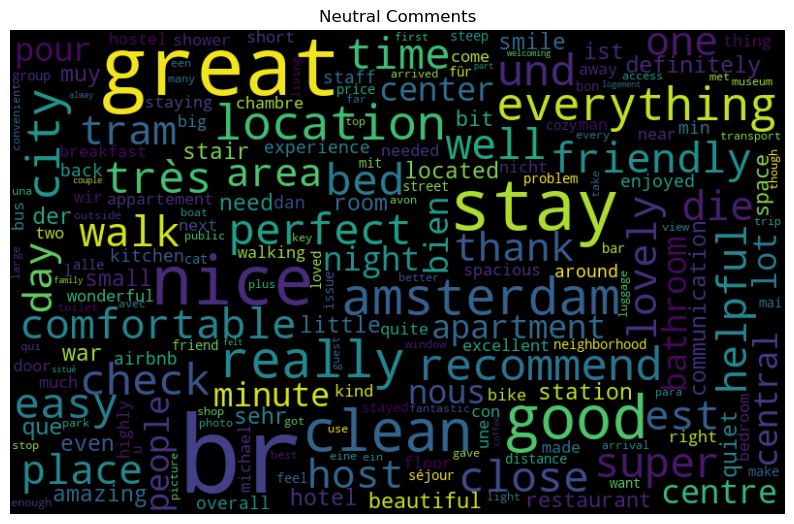

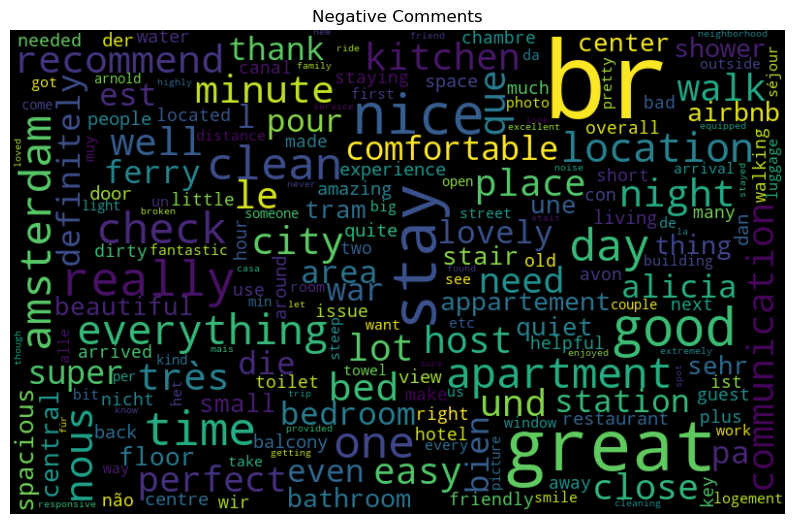

In [83]:
def plot_wordcloud(wordcloud, title):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

plot_wordcloud(positive_wordcloud, "Positive Comments")
plot_wordcloud(neutral_wordcloud, "Neutral Comments")
plot_wordcloud(negative_wordcloud, "Negative Comments")

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle

# import wordcloud
from wordcloud import WordCloud, STOPWORDS

c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# check the sys path to see if the current directory is in the path in colab
import sys
print(sys.path)


['c:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\python310.zip', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\DLLs', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1', '', 'C:\\Users\\Kyriakos\\AppData\\Roaming\\Python\\Python310\\site-packages', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\win32', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\Pythonwin']


In [ ]:
df = pd.read_csv('dataset\listings_comments.csv')

In [ ]:
# load comments embeddings
with open('embeddings\comments_embeddings.pkl', 'rb') as f:
    comments_embeddings = pickle.load(f)

In [ ]:
comments_embeddings.shape

(6998, 384)

In [ ]:
# pd.set_option('display.max_colwidth', None)
df.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'name', 'description', 'neighborhood_overview', 'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_n

In [ ]:
label  = df['review_scores_accuracy'].values

In [ ]:
# from embedding.py load the function visualize_3D
from visualization.embedding import *

In [ ]:
# from embeddings use the visualize_3D function to visualize the embeddings
visualize_3D(comments_embeddings, label, title="Comments Embeddings", method='tSNE', method_settings={"perplexity":30, "random_state":0})

: 

: 

In [ ]:
np.where(label < 4.5)[0]

array([  47,   60,   83,   98,  101,  164,  166,  196,  248,  250,  269,
        274,  293,  304,  323,  413,  430,  456,  488,  518,  637,  642,
        664,  671,  759,  810,  867,  880,  978, 1005, 1071, 1072, 1110,
       1122, 1185, 1216, 1274, 1308, 1383, 1387, 1415, 1548, 1633, 1651,
       1704, 1786, 1858, 1865, 1866, 1867, 1913, 1934, 2025, 2116, 2121,
       2217, 2262, 2271, 2281, 2442, 2615, 2635, 2638, 2688, 2721, 2766,
       2782, 2798, 2807, 2826, 2827, 2855, 2856, 2857, 2897, 2983, 3012,
       3022, 3032, 3060, 3070, 3073, 3074, 3110, 3134, 3151, 3172, 3187,
       3213, 3221, 3238, 3243, 3304, 3305, 3321, 3344, 3388, 3458, 3505,
       3517, 3518, 3526, 3552, 3568, 3579, 3674, 3675, 3681, 3695, 3700,
       3717, 3773, 3796, 3810, 3937, 3956, 3977, 3998, 4067, 4070, 4074,
       4075, 4076, 4088, 4115, 4124, 4131, 4133, 4136, 4153, 4166, 4175,
       4178, 4191, 4215, 4219, 4220, 4260, 4268, 4272, 4278, 4284, 4287,
       4302, 4304, 4305, 4307, 4312, 4326, 4360, 43

In [ ]:
print(df['comments'].isna().sum())
# fill the nan values
df['comments'].fillna('nan_value', inplace=True)

682


In [ ]:
df.shape

(6998, 76)

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

# define the stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
punctuations = set(string.punctuation)
# stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# for i in range(len(df.comments)):
#     if not isinstance(df.comments[i], list):
#         print(f"Non-string value found at index {i}: {df.comments[i]}")


# print the instance of each comme
# for i in range(len(df.comments)):
#     print(f"Instance of comment at index {i}: {type(df.comments[i])}")

In [ ]:
all_text[0:4]

"['Da"

In [ ]:
seperated_words = np.array([])

for sentence in enumerate(df.comments[:2]):
    words = sentence.split()
    # print(words)
    seperated_words.extend(words)
# flat_comments_str = ','.join(flat_comments)
# print(flat_comments_str[0])

(0, '[\'Daniel is really cool. The place was nice and clean. Very quiet neighborhood. He had maps and a lonely planet guide book in the room for you to use. I didnt have any trouble finding the place from Central Station. I would defintely come back! Thanks!\', \'Daniel is the most amazing host! His place is extremely clean, and he provides everything you could possibly want (comfy bed, guidebooks & maps, mini-fridge, towels, even toiletries). He is extremely friendly and helpful, and will go out of his way to help you if needed, or just let you come and go as you please. Highly recommended!\', \'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\\r<br/>Totally recom

AttributeError: 'tuple' object has no attribute 'split'

In [ ]:
# seperated_words
len(df['comments'].iloc[0])
type(df['comments'].iloc[0])

df['comments'].values

array([list(["['Daniel", 'really', 'cool.', 'The', 'place', 'nice', 'clean.', 'Very', 'quiet', 'neighborhood.', 'He', 'maps', 'lonely', 'planet', 'guide', 'book', 'room', 'use.', 'I', 'didnt', 'trouble', 'finding', 'place', 'Central', 'Station.', 'I', 'would', 'defintely', 'come', 'back!', "Thanks!',", "'Daniel", 'amazing', 'host!', 'His', 'place', 'extremely', 'clean,', 'provides', 'everything', 'could', 'possibly', 'want', '(comfy', 'bed,', 'guidebooks', 'maps,', 'mini-fridge,', 'towels,', 'even', 'toiletries).', 'He', 'extremely', 'friendly', 'helpful,', 'go', 'way', 'help', 'needed,', 'let', 'come', 'go', 'please.', 'Highly', "recommended!',", "'We", 'great', 'time', 'Amsterdam.', 'Daniel', 'excellent', 'host!', 'Very', 'friendly', 'everytime', 'helpful.', 'The', 'room', 'cozy,', 'comfortable,', 'VERY', 'clean.', 'Maps,', 'towels,', 'mini-fridge,', 'coffee', '(very', 'tasty)', 'tea', 'supplies', 'provided.', 'Bathroom', 'bathroom', 'requires.', 'Good', 'location', 'next', 'tram', '

In [ ]:
words

['nan_value']

In [ ]:
len(all_comments)
all_comments[0]

'[ \' d a n i e l   i s   r e a l l y   c o o l .   t h e   p l a c e   w a s   n i c e   a n d   c l e a n .   v e r y   q u i e t   n e i g h b o r h o o d .   h e   h a d   m a p s   a n d   a   l o n e l y   p l a n e t   g u i d e   b o o k   i n   t h e   r o o m   f o r   y o u   t o   u s e .   i   d i d n t   h a v e   a n y   t r o u b l e   f i n d i n g   t h e   p l a c e   f r o m   c e n t r a l   s t a t i o n .   i   w o u l d   d e f i n t e l y   c o m e   b a c k !   t h a n k s ! \' ,   \' d a n i e l   i s   t h e   m o s t   a m a z i n g   h o s t !   h i s   p l a c e   i s   e x t r e m e l y   c l e a n ,   a n d   h e   p r o v i d e s   e v e r y t h i n g   y o u   c o u l d   p o s s i b l y   w a n t   ( c o m f y   b e d ,   g u i d e b o o k s   &   m a p s ,   m i n i - f r i d g e ,   t o w e l s ,   e v e n   t o i l e t r i e s ) .   h e   i s   e x t r e m e l y   f r i e n d l y   a n d   h e l p f u l ,   a n d   w i l l   g o   o u t   o f   h 

In [ ]:
df.comments[0:2]

0    ['Daniel is really cool. The place was nice an...
1    ['Nice apartment in a beautifull área of Amste...
Name: comments, dtype: object

In [ ]:
import nltk
from nltk.corpus import stopwords

# define the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# initialize the concatenated array
concatenated_array = []

# iterate over each index in df.comments
for index in df.comments[0:2]:
    # join the strings in the index and split into individual words
    words = ' '.join(index).split()
    # remove the stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # append the filtered words to the concatenated array
    concatenated_array.append(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
words

['[',
 "'",
 'N',
 'i',
 'c',
 'e',
 'a',
 'p',
 'a',
 'r',
 't',
 'm',
 'e',
 'n',
 't',
 'i',
 'n',
 'a',
 'b',
 'e',
 'a',
 'u',
 't',
 'i',
 'f',
 'u',
 'l',
 'l',
 'á',
 'r',
 'e',
 'a',
 'o',
 'f',
 'A',
 'm',
 's',
 't',
 'e',
 'r',
 'd',
 'a',
 'm',
 '.',
 'I',
 't',
 'h',
 'a',
 's',
 'a',
 'v',
 'e',
 'r',
 'y',
 'g',
 'o',
 'o',
 'd',
 't',
 'r',
 'a',
 'n',
 's',
 'p',
 'o',
 'r',
 't',
 'c',
 'o',
 'n',
 'e',
 'x',
 'i',
 'ó',
 'n',
 '.',
 'M',
 'a',
 'r',
 'n',
 'i',
 'x',
 't',
 'r',
 'a',
 'a',
 't',
 'b',
 'u',
 's',
 's',
 't',
 'a',
 't',
 'i',
 'o',
 'n',
 '2',
 '0',
 '0',
 'm',
 'e',
 't',
 'e',
 'r',
 's',
 'a',
 'w',
 'a',
 'y',
 'a',
 'n',
 'd',
 'w',
 'e',
 'l',
 'l',
 'c',
 'o',
 'n',
 'n',
 'e',
 'c',
 't',
 'e',
 'd',
 'b',
 'y',
 't',
 'r',
 'a',
 'm',
 'w',
 'i',
 't',
 'h',
 't',
 'e',
 'm',
 'a',
 'i',
 'n',
 'p',
 'o',
 'i',
 'n',
 't',
 's',
 'o',
 'f',
 'i',
 'n',
 't',
 'e',
 'r',
 'e',
 's',
 't',
 '.',
 'A',
 'c',
 'r',
 'o',
 's',
 's',
 't',
 'e'

In [ ]:
from joblib import Parallel, delayed

# load comments
comments = df['comments'].values

# apply lambda function to the comments column and setence split all the setences and remove the stopwords and punctuations
df['comments'] = df['comments'].apply(lambda x: [word for word in ' '.join(x).split() if word not in stopwords and word not in punctuations])


# get the index of the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
index_high = np.where(label > 4.5)[0]
index_low = np.where(label < 4.5)[0]

comments_high = []
comments_low = []
# in each list in df['comments'].values pick the words with review_scores_accuracy > 4.5
# in each list in df['comments'].values, pick the words with review_scores_accuracy > 4.5
for i, comment in enumerate(comments):
    if i in index_high:
        comments_high.append(comment)
    elif i in index_low:
        comments_low.append(comment)

    


In [ ]:
# ## Visualize the words on the comments wich are corresponding to review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5

# # load comments 
# comments = df['comments'].values

# #  for each row in comments get the words and the corresponding embedding
# comments_words = []
# comments_words_embeddings = []
# for i in range(len(comments)):
#     # if isinstance(comments[i], str):
#         words = comments[i].split(" ")
#         for word in words:
#             comments_words.append(word)
#             comments_words_embeddings.append(comments_embeddings[i])

# # convert the comments_words_embeddings to numpy array
# comments_words_embeddings = np.array(comments_words_embeddings)

# # get the index of the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
# index_high = np.where(label > 4.5)[0]
# index_low = np.where(label < 4.5)[0]

# # get the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
# comments_high = comments_words_embeddings[index_high]
# comments_low = comments_words_embeddings[index_low]

# # get the words with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
# comments_words_high = np.array(comments_words)[index_high]
# comments_words_low = np.array(comments_words)[index_low]




In [ ]:
comments[0:2]

array(['[\'Daniel is really cool. The place was nice and clean. Very quiet neighborhood. He had maps and a lonely planet guide book in the room for you to use. I didnt have any trouble finding the place from Central Station. I would defintely come back! Thanks!\', \'Daniel is the most amazing host! His place is extremely clean, and he provides everything you could possibly want (comfy bed, guidebooks & maps, mini-fridge, towels, even toiletries). He is extremely friendly and helpful, and will go out of his way to help you if needed, or just let you come and go as you please. Highly recommended!\', \'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\\r<br/>Totally re

In [ ]:
# load comments 
comments = df['comments'].values

# get the words and the corresponding embedding for each comment
comments_words = [word for comment in comments for sentence in comment for word in sentence.split()]
comments_words_embeddings = np.array([comments_embeddings[i] for i, comment in enumerate(comments)  for _ in comment for _ in comment.split()])

# get the index of the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
index_high = np.where(label > 4.5)[0]
index_low = np.where(label < 4.5)[0]

# get the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
comments_high = comments_words_embeddings[index_high]
comments_low = comments_words_embeddings[index_low]

# get the words with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
comments_words_high = np.array(comments_words)[index_high]
comments_words_low = np.array(comments_words)[index_low]


In [ ]:
comments_words_high.shape[0] ,comments_words_low.shape[0] 

(5890, 311)

In [ ]:
# remove stopwords from the comments_words_high
stopwords = set(STOPWORDS)
comments_words_high = [word for word in comments_words_high if word not in stopwords]
comments_words_low = [word for word in comments_words_low if word not in stopwords]

len(comments_words_high), len(comments_words_low)




(3456, 166)

In [ ]:
comments_words_high[0]

"['Daniel"

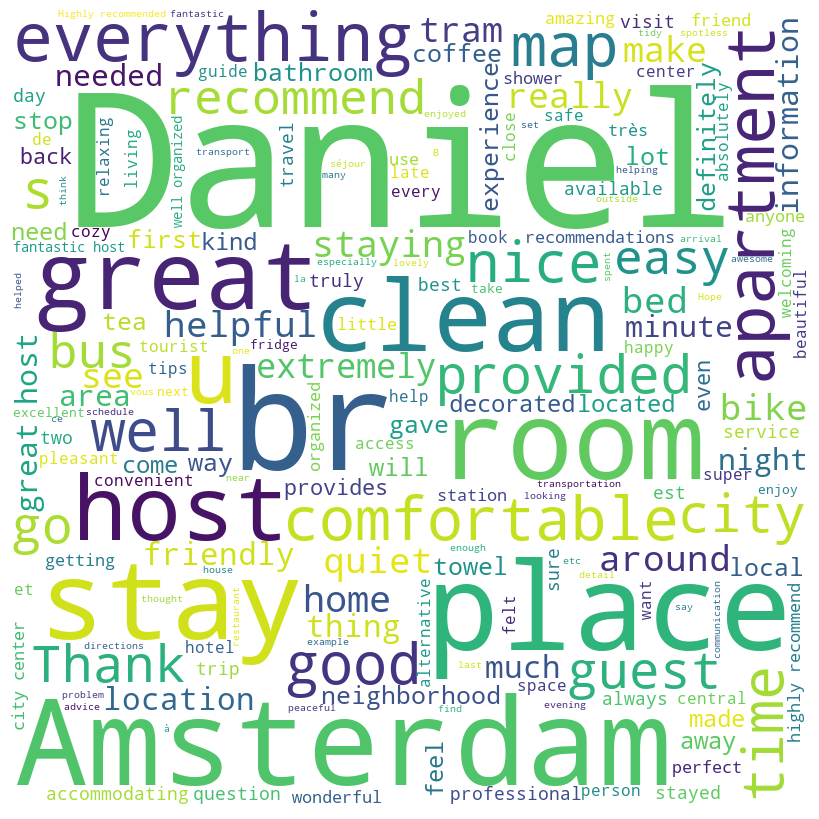

In [ ]:

import matplotlib.pyplot as plt

# create the wordcloud for the comments with review_scores_accuracy > 4.5
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(comments_words_high))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [50]:
# ## Visualize the words on the comments wich are corresponding to review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5

# # load comments 
# comments = df['comments'].values

# #  for each row in comments get the words and the corresponding embedding
# comments_words = []
# comments_words_embeddings = []
# for i in range(len(comments)):
#     # if isinstance(comments[i], str):
#         words = comments[i].split(" ")
#         for word in words:
#             comments_words.append(word)
#             comments_words_embeddings.append(comments_embeddings[i])

# # convert the comments_words_embeddings to numpy array
# comments_words_embeddings = np.array(comments_words_embeddings)

# # get the index of the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
# index_high = np.where(label > 4.5)[0]
# index_low = np.where(label < 4.5)[0]

# # get the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
# comments_high = comments_words_embeddings[index_high]
# comments_low = comments_words_embeddings[index_low]

# # get the words with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
# comments_words_high = np.array(comments_words)[index_high]
# comments_words_low = np.array(comments_words)[index_low]




In [53]:
comments[0:2]

array(['[\'Daniel is really cool. The place was nice and clean. Very quiet neighborhood. He had maps and a lonely planet guide book in the room for you to use. I didnt have any trouble finding the place from Central Station. I would defintely come back! Thanks!\', \'Daniel is the most amazing host! His place is extremely clean, and he provides everything you could possibly want (comfy bed, guidebooks & maps, mini-fridge, towels, even toiletries). He is extremely friendly and helpful, and will go out of his way to help you if needed, or just let you come and go as you please. Highly recommended!\', \'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\\r<br/>Totally re

In [17]:
# load comments 
comments = df['comments'].values

# get the words and the corresponding embedding for each comment
comments_words = [word for comment in comments for sentence in comment for word in sentence.split()]
comments_words_embeddings = np.array([comments_embeddings[i] for i, comment in enumerate(comments)  for _ in comment for _ in comment.split()])

# get the index of the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
index_high = np.where(label > 4.5)[0]
index_low = np.where(label < 4.5)[0]

# get the comments with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
comments_high = comments_words_embeddings[index_high]
comments_low = comments_words_embeddings[index_low]

# get the words with review_scores_accuracy > 4.5 and review_scores_accuracy < 4.5
comments_words_high = np.array(comments_words)[index_high]
comments_words_low = np.array(comments_words)[index_low]


In [55]:
comments_words_high.shape[0] ,comments_words_low.shape[0] 

(5890, 311)

In [59]:
# remove stopwords from the comments_words_high
stopwords = set(STOPWORDS)
comments_words_high = [word for word in comments_words_high if word not in stopwords]
comments_words_low = [word for word in comments_words_low if word not in stopwords]

len(comments_words_high), len(comments_words_low)




(3456, 166)

In [61]:
comments_words_high[0]

"['Daniel"

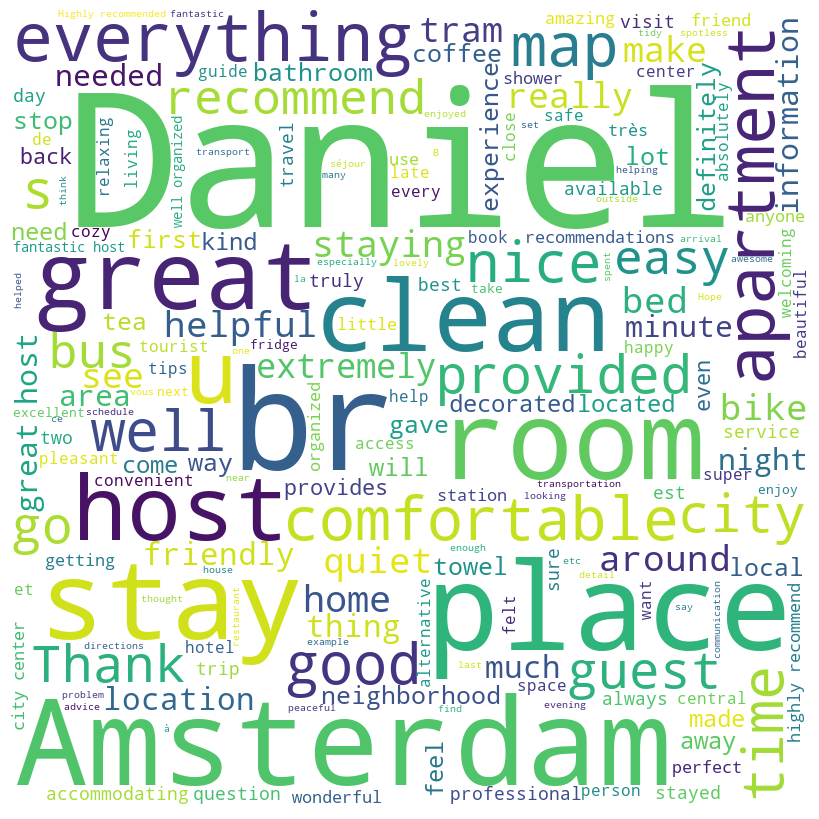

In [54]:

import matplotlib.pyplot as plt

# create the wordcloud for the comments with review_scores_accuracy > 4.5
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(comments_words_high))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()